### **ENVIRONMENT SETUP**

In [1]:
! pip install -q emoji pyLDAvis

### **IMPORT LIBRARIES**

In [3]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [91]:
import pandas as pd
import numpy as np
import re
import emoji
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from bs4 import BeautifulSoup

In [98]:
import os
import re
import string
import json
import emoji
from collections import Counter
import gensim
import warnings
warnings.filterwarnings('ignore')

In [99]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/sri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sri/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/sri/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

### **LOAD DATASET**

In [44]:
df_train = pd.read_csv("data/train.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])
df_dev = pd.read_csv("data/dev.tsv", sep='\t', header=None, names=['Text', 'Class', 'ID'])

In [45]:
df_train['List of classes'] = df_train['Class'].apply(lambda x: x.split(','))
df_train['Len of classes'] = df_train['List of classes'].apply(lambda x: len(x))

df_dev['List of classes'] = df_dev['Class'].apply(lambda x: x.split(','))
df_dev['Len of classes'] = df_dev['List of classes'].apply(lambda x: len(x))

In [46]:
with open('data/ekman_mapping.json') as file:
    ekman_mapping = json.load(file)

In [47]:
emotion_file = open("data/emotions.txt", "r")
emotion_list = emotion_file.read()
emotion_list = emotion_list.split("\n")

In [48]:
def idx2class(idx_list):
    arr = []
    for i in idx_list:
        arr.append(emotion_list[int(i)])
    return arr

In [49]:
df_train['Emotions'] = df_train['List of classes'].apply(idx2class)
df_dev['Emotions'] = df_dev['List of classes'].apply(idx2class)

In [50]:
def EmotionMapping(emotion_list):
    map_list = []
    for i in emotion_list:
        if i in ekman_mapping['anger']:
            map_list.append('anger')
        if i in ekman_mapping['disgust']:
            map_list.append('disgust')
        if i in ekman_mapping['fear']:
            map_list.append('fear')
        if i in ekman_mapping['joy']:
            map_list.append('joy')
        if i in ekman_mapping['sadness']:
            map_list.append('sadness')
        if i in ekman_mapping['surprise']:
            map_list.append('surprise')
        if i == 'neutral':
            map_list.append('neutral')
    return map_list

In [51]:
df_train['Mapped Emotions'] = df_train['Emotions'].apply(EmotionMapping)
df_dev['Mapped Emotions'] = df_dev['Emotions'].apply(EmotionMapping)

In [52]:
df_train['anger'] = np.zeros((len(df_train),1))
df_train['disgust'] = np.zeros((len(df_train),1))
df_train['fear'] = np.zeros((len(df_train),1))
df_train['joy'] = np.zeros((len(df_train),1))
df_train['sadness'] = np.zeros((len(df_train),1))
df_train['surprise'] = np.zeros((len(df_train),1))
df_train['neutral'] = np.zeros((len(df_train),1))

df_dev['anger'] = np.zeros((len(df_dev),1))
df_dev['disgust'] = np.zeros((len(df_dev),1))
df_dev['fear'] = np.zeros((len(df_dev),1))
df_dev['joy'] = np.zeros((len(df_dev),1))
df_dev['sadness'] = np.zeros((len(df_dev),1))
df_dev['surprise'] = np.zeros((len(df_dev),1))
df_dev['neutral'] = np.zeros((len(df_dev),1))

# Fill the column with the corresponding emotions
for i in ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise','neutral']:
    df_train[i] = df_train['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)
    df_dev[i] = df_dev['Mapped Emotions'].apply(lambda x: 1 if i in x else 0)

In [53]:
df_train.drop(df_train[df_train['neutral'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['neutral'] == 1].index, inplace=True)

df_train.drop(df_train[df_train['disgust'] == 1].index, inplace=True)
df_dev.drop(df_dev[df_dev['disgust'] == 1].index, inplace=True)

In [54]:
df_train.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)
df_dev.drop(['Class', 'List of classes', 'Len of classes', 'Emotions', 'Mapped Emotions', 'neutral', 'disgust'], axis=1, inplace=True)

### **DATA PREPROCESSING**

In [55]:
contraction_mapping = {
    "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
    "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
    "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
    "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
    "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
    "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
    "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
    "might've": "might have","mightn't": "might not", "mightn't've": "might not have", "must've": "must have", 
    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
    "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
    "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
    "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
    "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
    "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
    "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
    "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
    "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
    "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
    "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 
    'e.g':'for example'
}

# Function to expand the contractions

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    # Uniform apostrophe
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
        
    # Expand the words using mapping
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
            
    # Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Create space b/w word and punctuation following it
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

In [56]:
# List of punctuations

punct = [
    ',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',
    '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
    '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
    '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', 
    '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', 
    '‡', '√', 
]

# Mapping for punctuations

punct_mapping = {
    "‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
    "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
    'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '
}

In [57]:
# Dictionary to correct the misspellings

mispell_dict = {
    'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 
    'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 
    'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 
    'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 
    'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', 
    "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', 
    '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 
    'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization'
}

# Function to correct the misspellings

def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

In [58]:
# Function to clean the text

def clean_text(text):
    text = emoji.demojize(text) # Remove emojis
    text = re.sub(r'\:(.*?)\:','',text) 
    text = str(text).lower() # Make text lowercase
    text = re.sub('\[.*?\]', '', text) # Remove text inside square brackets
    text = BeautifulSoup(text, 'lxml').get_text() # Remove html
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove links
    text = re.sub('<.*?>+', '', text) # Remove text inside angular brackets
    text = re.sub('\n', '', text) # Remove newlines
    text = re.sub('\w*\d\w*', '', text) # Remove words that contain numbers
    # Replace everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

In [59]:
# Function to remove any special characters

def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])
    for p in punct:
        text = text.replace(p, f' {p} ')
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''} # List of special characters
    for s in specials:
        text = text.replace(s, specials[s])
    return text

# Function to remove any extra spaces

def remove_space(text):
    text = text.strip()
    text = text.split()
    return " ".join(text)

In [60]:
# Function to perform the entire preprocessing

def text_preprocessing_pipeline(text):
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [61]:
df_train['Text'] = df_train['Text'].apply(text_preprocessing_pipeline)
df_dev['Text'] = df_dev['Text'].apply(text_preprocessing_pipeline)

In [62]:
df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)

In [66]:
text = []

for ele in df_train["Text"].values:
    text.append(ele)
for ele in df_dev["Text"].values:
    text.append(ele)

In [82]:
df = pd.concat([df_train, df_dev])

### **VISUALIZATION**

#### Character level exploration

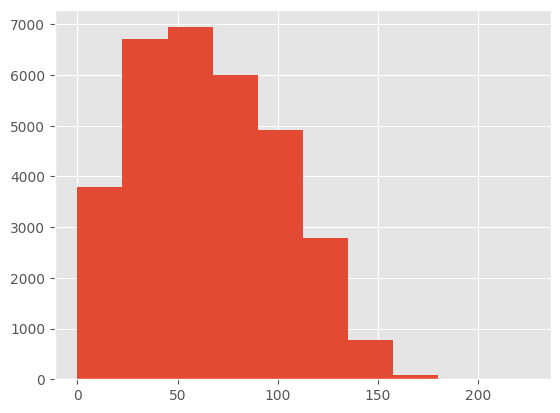

In [83]:
x = [len(x) for x in text]
plt.style.use('ggplot')
plt.hist(x)
plt.show()

#### Word level exploration

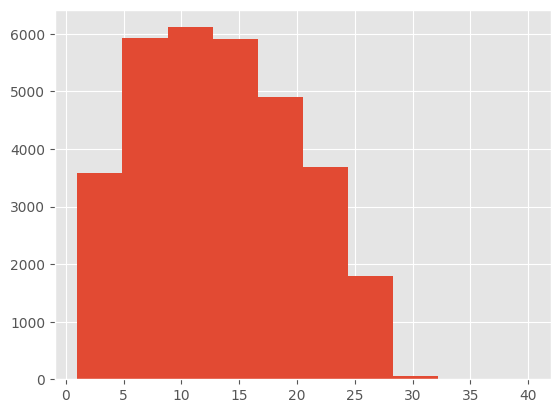

In [84]:
x = [len(x.split(" ")) for x in text]
plt.style.use('ggplot')
plt.hist(x)
plt.show()

#### Top 10 stopwords used

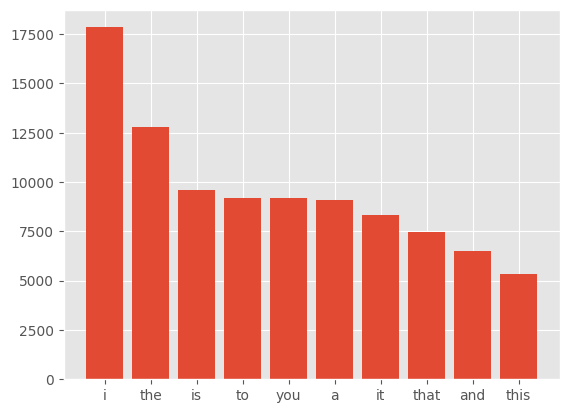

In [85]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)

plot_top_stopwords_barchart(df['Text'])

#### Common words other than stopwords

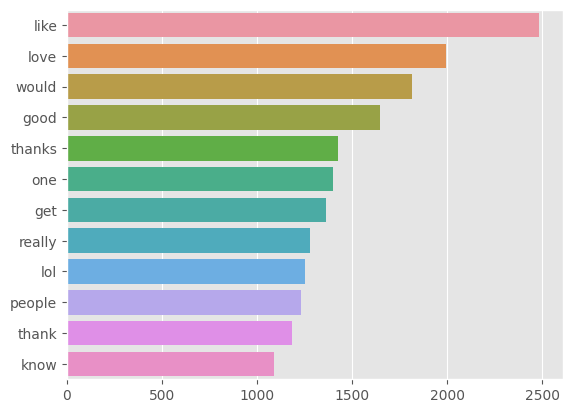

In [92]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new_ = text.str.lower()
    new = new_.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y=[], []
    for word,count in most[:60]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x)
    
plot_top_non_stopwords_barchart(df['Text'])

#### N-gram Exploration

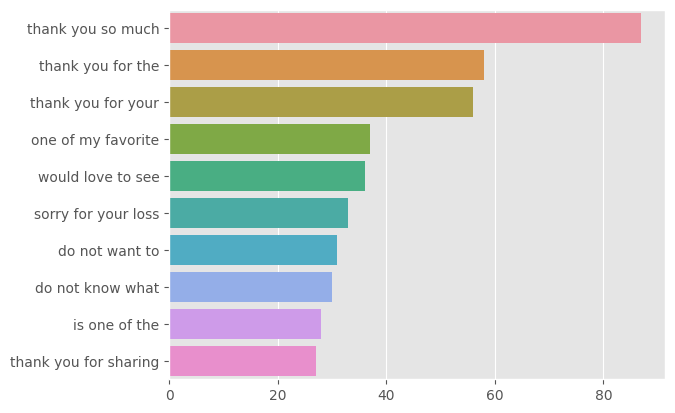

In [95]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new_ = text.str.lower()
    new= new_.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    
plot_top_ngrams_barchart(df['Text'],4)

#### Topic Modeling

In [100]:
def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 4, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis

lda_model, bow_corpus, dic = get_lda_objects(df['Text'])

lda_model.show_topics()

plot_lda_vis(lda_model, bow_corpus, dic)

[nltk_data] Downloading package stopwords to /home/sri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/sri/Documents/SIN J Component/emotion-classification/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/sri/Documents/SIN J Component/emotion-classification/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/sri/Documents/SIN J Component/emotion-classification/venv/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation fo

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.029278  0.104002       1        1  29.054337
0     -0.106155  0.070798       2        1  27.270559
3     -0.071567 -0.167802       3        1  24.948782
2      0.207000 -0.006998       4        1  18.726322, topic_info=        Term         Freq        Total Category  logprob  loglift
15      good  1492.000000  1492.000000  Default  30.0000  30.0000
25    thanks  1332.000000  1332.000000  Default  29.0000  29.0000
82     thank  1072.000000  1072.000000  Default  28.0000  28.0000
389     like  2256.000000  2256.000000  Default  27.0000  27.0000
49       lol  1144.000000  1144.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
519  thought   133.778570   428.828933   Topic4  -5.6250   0.5104
583     work   131.638440   434.498733   Topic4  -5.6411   0.4811
62      time   155.402928   942.786866   Topic4  -5.4752  -0.1276
52      sure   123.507685   483.222586   Topic4  -5.7049   0.3111
116      see   129.008605   792.835811   Topic4  -5.6613  -0.1405

[309 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
226       1  0.766590  actually
226       2  0.202380  actually
226       3  0.030664  actually
2810      1  0.987003  adorable
1380      2  0.784239    advice
...     ...       ...       ...
2861      3  0.979707       yep
27        1  0.175615       yes
27        2  0.181103       yes
27        3  0.096040       yes
27        4  0.546054       yes

[521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

#### Word Clouds

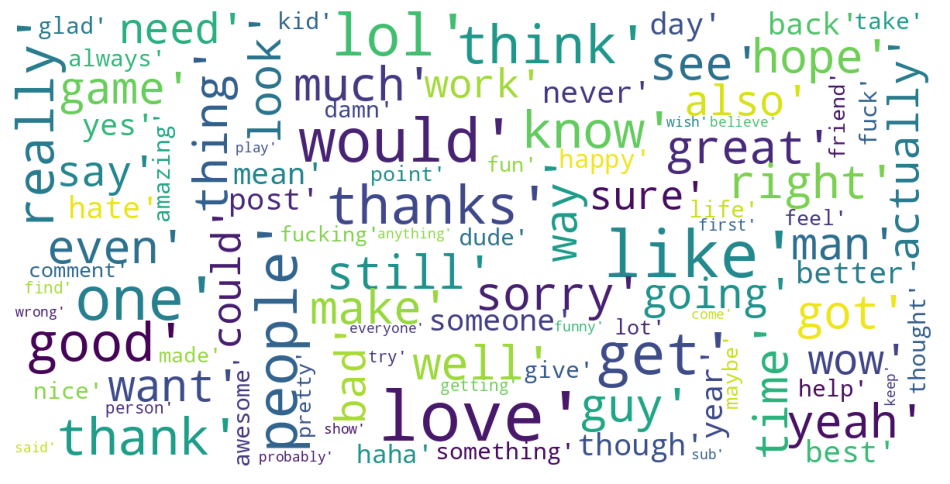

In [104]:
def plot_wordcloud(text):

    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()
    
plot_wordcloud(df['Text'])

In [106]:
anger = df['anger'].sum()
fear = df['fear'].sum()
joy = df['joy'].sum()
sadness = df['sadness'].sum()
surprise = df['surprise'].sum()

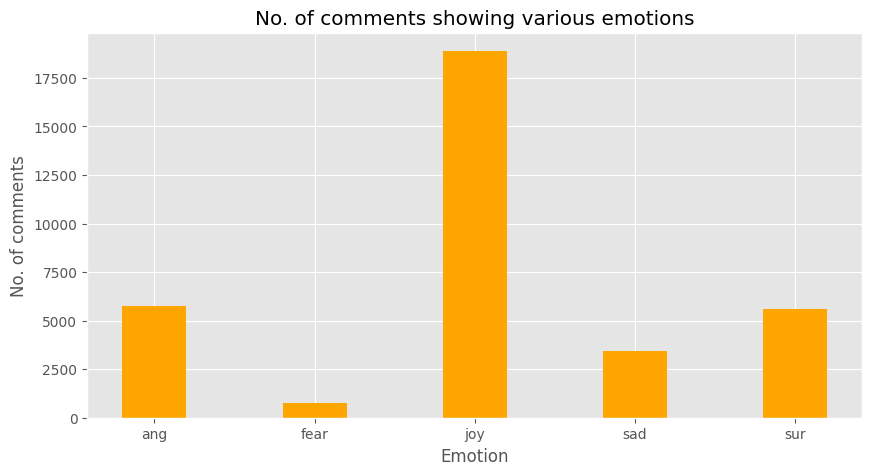

In [109]:
data = {'ang':anger, 'fear':fear, 'joy':joy, 'sad':sadness, 'sur':surprise}

emotion_key = list(data.keys())
emotion_value = list(data.values())

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(emotion_key, emotion_value, color ='orange',
        width = 0.4)
 
plt.xlabel("Emotion")
plt.ylabel("No. of comments")
plt.title("No. of comments showing various emotions")
plt.show()

#Highest - neutral
#lowest grief
#next highest - admiration and approval

In [110]:
emotion_list = list(data.keys())
emotion_value1 = list(data.values())
emotion_value1 = np.array(emotion_value1)

In [111]:
emotion_value1

array([ 5777,   782, 18880,  3456,  5615])

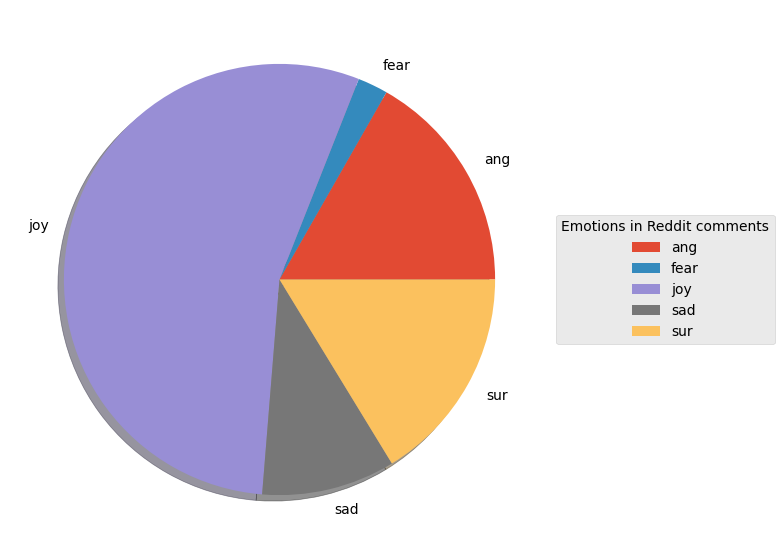

In [112]:
emotion_list = list(data.keys())
emotion_value = list(data.values())
emotion_value = np.array(emotion_value)
y = emotion_value
mylabels = emotion_list
fig, ax = plt.subplots(figsize =(20, 7))
plt.pie(y, labels = mylabels, shadow = True,)
plt.legend(title = "Emotions in Reddit comments", loc ="center left",bbox_to_anchor =(1, 0, 0.5, 1))
plt.show() 